# Grover's Algorithm Sudoku Solver: Introduction

The goal of this project is to implement an $n^2\times n^2$ sudoku solver using Grover's algorithm. A valid solution requires that each row and column contains the symbols $\{0,\dots,n^2-1\}$ each exactly once, and each $n\times n$ sub-block contrain the symbols $\{0,\dots,n^2-1\}$ exacly once. For instance,




$$\left[\begin{array}{cc|cc}
0 & 1 & 2 & 3\\
2 & 3 & 0 & 1\\
\hline 1 & 2 & 3 & 0\\
3 & 0 & 1 & 2
\end{array}\right]$$
is a valid $2^2\times 2^2$ sudoku solution.

To start, import the necessary packages.

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt
from pylatexenc import *
import numpy as np

The first thing we will use regularly throughout this project is a multi-controlled $X$ gate, denoted $C^nX$, which acts on a length $n$ bit string via $$
C^nX\ket{x_0\dots x_n} = \begin{cases}
\ket{x_0\dots x_{n-1}} \otimes X\ket{x_n} & \text{if }x_0=\dots=x_{n-1} = 1\\
\ket{x_0\dots x_n} &\text{else}\end{cases}.$$

Such a gate can be built from a ladder of Tofolli gates as follows: suppose we want three qubits $\ket{c_0 c_1 c_2}$ controlling a fourth target qubit $\ket{t}$ on which the $X$ gate can act. We introduce a single ancilla qubit $\ket{a}$. Initializing the target and ancillary qubit to $\ket{0}$, we can act on $\ket{a}$ with a Tofolli gate controlled by $\ket{c_0c_1}$, so that $a = c_0 \land c_1$. Then, we can act on $\ket{t}$ with a Tofolli gate controlled by $a$ and $c_2$, so that $t = a\land c_2 = (c_0\land c_1)\land c_2 = c_0\land c_1\land c_2$ since $\land$ is associative. Then $t = 1$ if all $c_0=\dots c_2 =1$ and is zero otherwise, which was the goal. We then reinitialize $\ket{a}$ by acting again with the same Tofolli gate as before, resulting in $\ket{t}$ having been controlled by $\ket{c_0\dots c_2}$. We can extend this to $n$ control bitss with the following function, using $n-2$ ancilla bits:

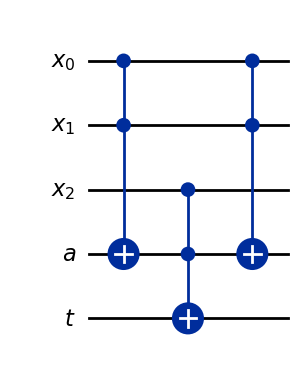

In [2]:
def MCX(circuit,control,target,ancillas = [],decompose = True):

  """
Adds a multicontrolled X gate to 'circuit,' controlled by 'control', acting on 'target'.
If decompose == True, my implementation requires (k-2)-many ancilla qubits for k control bits. These are given in the 'ancillas' argument.
If decompose == False, this function uses qiskit's built in multicontrolled X implementation, which requires no ancillas.
  """


# Check how many control bits are used. For 0,1, or 2 controls we can use and X gate, CX gate, or Tofolli gate, respectively.

  if len(control) == 0:
      circuit.x(target)

  elif len(control) == 1:
      circuit.cx(control,target)

  elif len(control) == 2:
      circuit.ccx(*control,target)

# If decompose == False, use the built in qiskit multicontrolled X gate implementation.

  elif decompose == False:
      circuit.mcx(control,target)

  else:
      n = len(control)+1

      if n - 3 != len(ancillas): # Verify correct number of ancilla bits provided.
          raise ValueError(f"MCX requires {len(control)-2} ancillas, and there was (were) {len(ancillas)} provided")

# Implement the chain of Tofolli gates as described in the above section.
      circuit.ccx(control[0],control[1],ancillas[0])

      for i in range(n-4):
          circuit.ccx(control[i+2],ancillas[i],ancillas[i+1])

      circuit.ccx(control[n-2],ancillas[n-4],target)

# Uncompute:
      for i in range(n-4):
          i = (n-5)-i
          circuit.ccx(control[i+2],ancillas[i],ancillas[i+1])

      circuit.ccx(control[0],control[1],ancillas[0])

# Test Case: Feel free to change the value of n to see the circuit in different cases!
n = 3
control = QuantumRegister(size = n,name = 'x')
target = QuantumRegister(size = 1,name = 't')
ancilla = AncillaRegister(size = n-2, name = 'a')

qc = QuantumCircuit(control,ancilla,target)

MCX(qc,control,target,ancilla)

qc.draw(output= 'mpl')

# Warm Up: $2\times 2$ Case

To illustrate the method, we will implement our solver on a $2\times 2$ grid as a warm up case. Since 2 is not the square of some other integer, it does not make sense to check uniqueness of entries in a $\sqrt{2}\times \sqrt{2}$ sub-block, but we can still verify all the rows and columns contain the symbols $\{0,1\}$ exactly once. Such a solution is called a Latin square.

Given such rules, there are only two possible solutions, namely: $$ \begin{bmatrix} 0 & 1\\
1 & 0\end{bmatrix} \text{ and } \begin{bmatrix} 1 & 0 \\
0 & 1\end{bmatrix}$$ Let us denote the entries of the sudoku by $$\begin{bmatrix} x_0 & x_1\\ x_2 & x_3\end{bmatrix}.$$

We first introduce two functions that help us parse a given array for use in our implementation of Grover's algorithm. The first function extracts the locations of the unknown entries in the square, i.e. for $$\begin{bmatrix} 0 & \cdot\\
1 & 0\end{bmatrix}$$ it would return $(0,1)$, indicating the the 0th row and 1st column contains an unknown entry.

The second function generates a list of all the elements to which the unknown entries must be compared. In the example above, the entry at $(0,1)$ would need to be compared with the entry in the same row $(0,0)$ and the entry in the same column $(1,1)$. For later use in our program, we distinguish between comparisons between two entries that are both unknown (called an "unknown comparison") and two entries for which one value is provided in the puzzle and the other is unknown (called a "fixed comparison").

In [3]:
def unknown_entries2x2(A):
  """
A: 2x2 array or list of lists containing the values '0', '1', and 'None' encoding the positions
  of unknown entries

  Returns a list of tuples encoding the row and column index of all unknown entries
  """
  # Makes sure A is encoded as an array
  A = np.array(A)
  # Create a list to store unknown entry locations
  unknown_entries = []
  # Loop through all entries to find where unknown entries are and store them
  for i in range(2):
      for j in range(2):
          if A[i,j] == None:
              unknown_entries.append((i,j))

  # Return list of unknown entry locations
  return unknown_entries

def generate_comparisons2x2(unknown):
  """
  unknown: A list of 2-component tuples encoding the unknown entries for an array.

  Returns a list of sets of tuples indicating which entries must be compared to
  verify a solution is obtained.
  """

  # Create a list to store all the entries that must be compared
  comparison_list = []

  # For each unknown entry, iterate the row and column index
  # to generate all the indices which must be compared to that
  # unknown entry
  for x in unknown:
      for i in range(2):
          if x[1] != i:
              comparison_list.append({x,(x[0],i)})
          if x[0] != i:
              comparison_list.append({x,(i,x[1])})

  # Create lists to store when an unknown entry is compared to a known/fixed
  # entry, and when we are comparing two unknown entries.

  fixed_comparison = []
  unknown_comparison = []

  # Goes through the comparison_list generated in the last loop, and any element
  # appearing twice must have come from an unknown entry-unknown entry comparison
  for pair in comparison_list:
      if comparison_list.count(pair) == 1:
          fixed_comparison.append(pair)
      elif pair not in unknown_comparison:
          unknown_comparison.append(pair)

  # Return two lists of sets of tuples enumerating the comparisons between
  # two unknown entries and a known-to-unknown entry.
  return fixed_comparison,unknown_comparison


# Test Case: Change the 'test_puzzle' variable to any valid 2x2 array of '0','1', and 'None'.
# Should print out the list of entries containing 'None', and all the comparisons that must be checked.

test_puzzle = np.array([[None,0],[None,1]])

unknown = unknown_entries2x2(test_puzzle)
print(unknown)
print(generate_comparisons2x2(unknown))

[(0, 0), (1, 0)]
([{(0, 1), (0, 0)}, {(1, 0), (1, 1)}], [{(1, 0), (0, 0)}])


The next function we require is one that compares two entries in our puzzle to see if they are the same or equal. In the case of a unknown-unknown comparison (comparing an unknown value to an unknown value), we do the following. Suppose we want to verify two qubits $\ket{x}_n$ and $\ket{y}_n$ are not equal. The simplest way is to check if they are equal and then negate the answer. This is done by comparing their values bitwise with controlled $X$ gates using $\ket{x_i}$ as the control and acting on $\ket{y_i}$ -- then $\ket{y_i} = 0$ if and only if $x_i=y_i$. We then flip $\ket{y_i}$ with an $X$ gate before using our multicontrolled $X$ gate controlled by $\ket{y}_n$, acting on some target gate $\ket{t}$ which was initialized to $\ket{0}$. Then $\ket{t} = \ket{1}$ if and only if $\ket{x} = \ket{y}$. Finally, we negate $\ket{t}$ with an $X$ gate so $\ket{t} = \ket{1}$ if and only if $\ket{x}\not = \ket{y},$ and then uncompute on $\ket{y}$.

For an unknown-known comparison, say veryifing that $\ket{x_0\dots x_n} \not = k$ for $k\in\mathbb{N}$, we first encode $k$ as a binary number $(z_0\dots z_{n})$ and then act with an $X$ gate on each qubit $\ket{x_i}$ for which $z_i=0$. This will make $$\ket{x_i} = \begin{cases} \ket{1} & x_i = 0\\
\ket{0} & x_i = 1\end{cases},$$  or in other words makes $x_i = 1$ if $x_i = z_i$ and zero otherwise. Then we act a multicontrolled $X$ gate on some target qubit $\ket{t}$ controlled by $\ket{x_0\dots x_n}$. The result is that $\ket{t} = \ket{1}$ if and only if $x_0\dots x_n = z_0\dots z_n$. We negate the result of $t$ so that $\ket{t} = \ket{1}$ if and only if $x_0\dots x_n \not = z_0\dots z_n$, and finally uncompute on $\ket{x_0\dots x_n}$ to restore their original values.

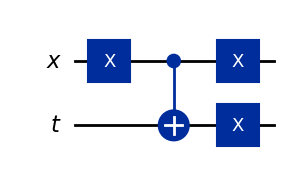

In [4]:
def XOR(circuit,a,b,target,ancilla = [],both_qubits = False, decompose = False):
  """
  Verifies that sets of qubits are distinct, or that a set of qubits is distinct from the binary
  represenation of a particular number.

  circuit: quantum circuit on which the gates are implemented
  a: (list of) qubit(s) that are being compared to another qubit or a particular number
  b: (list of) qubit(s) being compared to 'a', or an integer being compared to 'a'.
  ancilla: stores ancilla qubits used in my MCX implementation. Not needed if decompose == False.
          If 'a' (and 'b') are n-bit qubits, requires n-2 ancillas.
  target: a single qubit storing 1 if 'a' and 'b' are distinct and '0' if not.
  both_qubits: Boolean that reads 'True' is b is a (list of) qubit(s), or 'False' if b is an integer.
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.
  """

  # If both 'a' and 'b' are (lists of) qubits, compare them as described above.
  if both_qubits == True:
      for i in range(len(a)):
          circuit.cx(a[i],b[i])
          circuit.x(b[i])

      MCX(circuit,b,target,ancilla,decompose = decompose)
      circuit.x(target)

      for i in range(len(a)):
          circuit.x(b[i])
          circuit.cx(a[i],b[i])

  # If both 'a' is a (list of) qubit(s) and 'b' is an integer, compare them as described above.
  else:
      binary = f'{b:0{len(a)}b}'

      for j in [i for i in range(len(a)) if binary[i] == '0']:
          circuit.x(a[j])

      MCX(circuit,a,target,ancilla,decompose = decompose)
      circuit.x(target)

      for j in [i for i in range(len(a)) if binary[i] == '0']:
          circuit.x(a[j])

## Test Case 1: Comparing two n-bit qubits.

# n = 4
# qubit = QuantumRegister(size = 2*n, name = 'x')
# target = QuantumRegister(size = 1, name = 't')
# if n -2 > 0:
#     ancilla = AncillaRegister(size = n-2,name = 'a')
# else:
#     ancilla = []

# qc = QuantumCircuit(qubit,target,ancilla)

# XOR(qc,qubit[:n],qubit[n:],target,ancilla,True,decompose = False)

# qc.draw(output='mpl')

## Test Case 2: Comparing an n-bit qubit with a particular integer

n = 1
qubit = QuantumRegister(size = n, name = 'x')
target = QuantumRegister(size = 1, name = 't')
if n -2 > 0:
    ancilla = AncillaRegister(size = n-2,name = 'a')
else:
    ancilla = []

qc = QuantumCircuit(qubit,ancilla,target)

XOR(qc,qubit,0,target,ancilla,False,decompose = True)

qc.draw(output='mpl')

We are now in a position to implement our marker oracle, by generating the list of entries in our puzzle to compare using the "generate_comparisons2x2" function, and then reading out whether or not the two entries in each comparison is or is not equal. We store these to some target registers and finally act one more multicontrolled $X$ gate controlled by these target registers to read out whether all entries in each comparison are distinct. The result is that our last register reads 1 when all elements in each comparison are distinct and zero otherwise. We act a $Z$ gate on this final register to flip the sign of the state when it has the value 1, and then uncompute.

In [5]:
def marker_oracle2x2(puzzle,decompose = True):
  """
  Implements a marker oracle that flips the sign of states that represent valid solutions, and preserves orthogonal states.

  puzzle: A 2x2 array or list of lists containing '0', '1', and 'None' as its entries representing our puzzle.
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.

  Returns a quantum circuit that implements the marker oracle.
  """

  # Ensure that the puzzle is an array
  puzzle = np.array(puzzle)

  # Find the location of unknown entries in the puzzle
  unknown = unknown_entries2x2(puzzle)

  # Create a dictionary mapping the (row,column) encoding of an unknown value to
  # the indices of the quantum registers encoding that qubit
  dictionary = {}

  for i in range(len(unknown)):
      dictionary[unknown[i]] = i


  # Generate a list of entries to which the unknown entries must be compared. Either
  # to a fixed entry (fixed_comparisons) or to one another (unknown_comparisons).
  fixed_comparisons, unknown_comparisons = generate_comparisons2x2(unknown)

  # Compute the total number of comparisons that must be implemented, which
  # tells us how many target qubits will be needed to store the result.
  num_of_comparisons = len(fixed_comparisons)+len(unknown_comparisons)

  # Create quantum registers to store the binary values for the unknown entries
  quantum_register = QuantumRegister(size = len(unknown), name = 'x')

  # Create the target registers that will store the truth value of the comparisons
  # as '0' or '1' (for 'False'/'True', respectively.)
  target_register = QuantumRegister(size = num_of_comparisons+1, name = 't')


  # Introduces the correct number of ancillas needed for our MCX implementation
  # if decompose == True, or does not create any ancillas if using the built in
  # qiskit implementation
  if num_of_comparisons > 2 and decompose == True:
      ancilla_register = AncillaRegister(size = num_of_comparisons - 2, name = 'a')
  else:
      ancilla_register = []

  # Create the quantum circuit gate called 'check' that checks if a solution is valid. The final target register
  # will read '1' at the end of the circuit if all the comparisons are valid for a correct puzzle solution,
  # or '0' otherwise.

  checks = QuantumCircuit(quantum_register,ancilla_register,target_register,name = 'checks')

  # Index which target register a given comparison will be stored in
  target_counter = 0

  # Compare each qubit to the entries that are known in its row/column using our XOR function,
  # storing the truth value as '0' (False) or '1' (True) in a target register.
  for qubit in unknown:
      for pair in fixed_comparisons:
          if qubit in pair:
              for entry in pair:
                  if entry != qubit:
                      XOR(checks,[quantum_register[dictionary[qubit]]],puzzle[entry],target_register[target_counter],both_qubits = False)
                      target_counter += 1

  # For any two unknown values in the same row/column, compare them using our XOR function,
  # storing the truth value as '0' (False) or '1' (True) in a target register.
  for pair in unknown_comparisons:
      first_index,second_index = pair
      XOR(checks,[quantum_register[dictionary[first_index]]],[quantum_register[dictionary[second_index]]],target_register[target_counter],both_qubits = True)
      target_counter += 1

  # Create a quantum circuit qc...

  qc = QuantumCircuit(quantum_register,ancilla_register,target_register,name = 'marker')

  # ... that will implement the 'check' gate...

  qc.compose(checks.to_gate(),inplace = True)

  # ... act an MCX controlled by all the targets storing the outcome of the previous checks acting on the final target qubit.
  MCX(qc,target_register[:target_counter],target_register[target_counter],ancilla_register,decompose=decompose)
  #  Then, this final target is acted on by a Z gate for the sign flip...
  qc.z(target_register[target_counter])
  # and then everything from the MCX and 'check' gate is uncomputed
  MCX(qc,target_register[:target_counter],target_register[target_counter],ancilla_register,decompose=decompose)
  qc.compose(checks.to_gate().inverse(),inplace = True)


  # Finally, return this whole circuit
  return qc

# Test Case: Verify this works for 'puzzle', and check that the statevector flips sign if the solution is valid.
puzzle = np.array([[None,1],[None,None]])

marker_oracle2x2(puzzle,decompose=False).draw(output = 'mpl')

Statevector(marker_oracle2x2(puzzle)).draw('Latex')

<IPython.core.display.Latex object>

The last element that is needed for implementing Grover's alogorithm is the diffuser circuit. The standard implementation of this circuit is done below, with the exception that the multicontrolled $Z$ gate in the diffuser uses the multicontrolled $X$ gate we have already constructed; i.e.,
$$H^{\otimes n}X^{\otimes n}C^{n-1}Z X^{\otimes n}H^{\otimes n}= H^{\otimes n}X^{\otimes n}(I^{\otimes n-1}\otimes H)C^{n-1}X(I^{\otimes n-1}\otimes H)  X^{\otimes n}H^{\otimes n}.$$

This circuit has the effect that the "equal superposition state" $\frac{1}{2^{n/2}}\sum_{x_i\in\mathbb{Z}_2}\ket{x_0\dots x_{n-1}}$ has its sign flipped, and states orthogonal to it are preserved.

In [6]:
def diffuser(n,decompose = True):
  """
  Implements the diffuser circuit described above acting on n qubits.

  n: Number of qubits storing the unknown values (positive integer)
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.

  Returns a quantum circuit that implements this diffuser.
  """
  ## Set up the quantum circuit

  # Introduce necessary number of quantum_registers and ancillas needed for the MCX implementation,
  # which depends on if decompose == True or False. Create a quantum circuit 'qc' with all the qubits.
  if decompose == True and n-3 >0:
      quantum_register = QuantumRegister(size = n, name = 'x')
      ancilla_register = AncillaRegister(size = n-3, name = 'a')
      qc = QuantumCircuit(quantum_register,ancilla_register,name = 'diffuser')
  else:
      quantum_register = QuantumRegister(size = n, name = 'x')
      ancilla_register = []
      qc = QuantumCircuit(quantum_register,name = 'diffuser')


  # Act H^n
  qc.h(quantum_register)
  # Act X^n
  qc.x(quantum_register)
  # Act C^nZ in terms of C^nX and Hadamard gates as described above
  qc.h(quantum_register[-1])
  MCX(qc,quantum_register[:-1],quantum_register[-1],ancilla_register,decompose = decompose)
  qc.h(quantum_register[-1])
  # Act X^n
  qc.x(quantum_register)
  # Act H^n
  qc.h(quantum_register)

  # Return the diffuser circuit.
  return qc

# Test Case: This generates the equal superposition state on n-qubits
# and verifies the sign flip by outputting the state vector. Feel free to change n!

n = 4
quantum_register = QuantumRegister(size = n, name = 'x')
if n-3 > 0:
  ancilla_register = AncillaRegister(size = n-3, name = 'a')
else:
  ancilla_register = []
qc = QuantumCircuit(quantum_register,ancilla_register)

qc.draw(output='mpl')
qc.h(quantum_register)

qc.compose(diffuser(n,decompose = True),inplace=True)
qc.draw(output='mpl')

Statevector(qc).draw('Latex')

<IPython.core.display.Latex object>

Finally, we implement Grover's algorithm by first preparing the state by acting a Hadamard gate on the qubits storing the unknown values (so that it begins in the "equal superposition state"), and then iteratively applying the marker and diffuser circuits a fixed number of times determined by the number of unknown qubits:

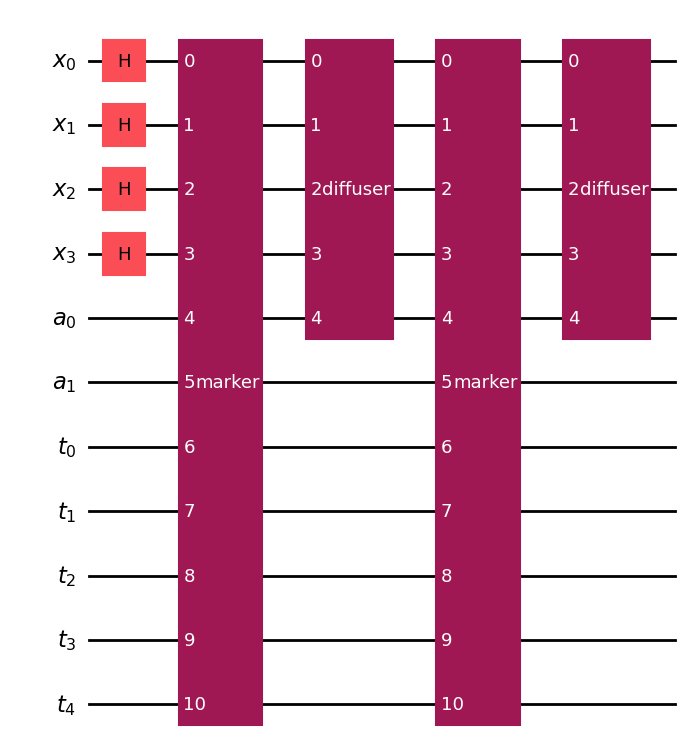

In [7]:
def Grover2x2(puzzle,decompose = True):
  """
  Implements Grover's alogirthm on a 2x2 latin square.

  puzzle: A 2x2 array or list of lists containing '0', '1', and 'None' as its entries representing our puzzle.
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.

  returns a circuit implementing Grover's algorithm to solve the puzzle!
  """

  # Determine locations unknown entries in the puzzle
  unknown = unknown_entries2x2(puzzle)

  # Generate a list of entries to which the unknown entries must be compared. Either
  # to a fixed entry (fixed_comparisons) or to one another (unknown_comparisons).
  fixed_comparisons, unknown_comparisons = generate_comparisons2x2(unknown)

  # Compute the total number of comparisons needed, which tells us how many target qubits
  # will be required to store the outcome.
  num_of_comparisons = len(fixed_comparisons)+len(unknown_comparisons)

  # Create quantum registers to store the binary values of unknown entries
  quantum_register = QuantumRegister(size = len(unknown), name = 'x')
  # Create target registers to store the outcome of all the comparisons.
  target_register = QuantumRegister(size = num_of_comparisons+1, name = 't')

  # Create the appropriate number of ancillas needed for MCX
  if num_of_comparisons > 2 and decompose == True:
      ancilla_register = AncillaRegister(size = num_of_comparisons - 2, name = 'a')
  else:
      ancilla_register = []


  # Create the quantum circuit on these qubits for Grover's alogrithmm
  grover_circuit = QuantumCircuit(quantum_register,ancilla_register,target_register,name = 'grover')

  # Compute the number of iterations requires to converge to correct answer with maximum probability.
  N = 2**len(unknown)
  K = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(N))) - 1/2))

  # Check for edge cases:
  if len(unknown) == 0:
      raise ValueError("Allow for at least one input to be unknown by replacing it with the value `None'")

  if len(unknown) == 1:
      print("Note that Grover's algorithm does not converge to a solution when we have a single, binary unknown!")

  if len(unknown) == 4:
      K = 2


  # Prepare the state into an equal superposition state
  grover_circuit.h(quantum_register)

  # Create gates implementing the appropriate marker and diffuser circuits
  marker_circuit = marker_oracle2x2(puzzle,decompose).to_gate()
  diffuser_circuit = diffuser(len(unknown),True).to_gate()


  # Iteratively apply the marker and diffuser gates the appropraite number of times
  for i in range(K):
      grover_circuit.compose(marker_circuit, inplace=True)
      grover_circuit.compose(diffuser_circuit,inplace=True)

  # Return the circuit implementing Grover's alogrithm
  return grover_circuit

# Verify the circuit diagram seems correct:

puzzle = np.array([[None,None],[None,None]])
Grover2x2(puzzle,decompose=True).draw(output='mpl')

Finally, we package the previous circuit into a user-friendly function that implements it and outputs the result for the unknown entries as a list:

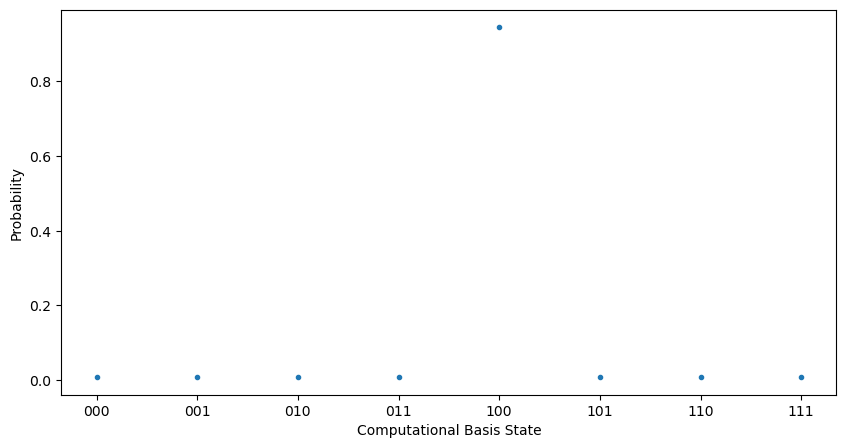

[0, 0, 1]

In [8]:
def solve_puzzle2x2(puzzle,decompose = True,showPlot = False):
  """
  User-friendly function packaging the implementation of Grover's algorithm to solve
  a 2x2 Latin square.

  puzzle: A 2x2 array or list of lists containing '0', '1', and 'None' as its entries representing our puzzle.
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.
  showPlot: Boolean that reads 'True' if user wishes to see a plot of the probability of all possible measurements
            of the qubits storing the unknown value state.

  Return a list of decimal numbers (integers) that correspond to the values of the unknown entries in the puzzle.
  These fill in the missing spaces in the puzzle in order, reading the puzzle from left-to-right and top-to-bottom.
  """
  # How many bits are needed to store each unknown value
  bit_length = 1

  # Obtain location of unknown entries, mainly to know how many unknown,
  # entries there are
  unknown = unknown_entries2x2(puzzle)

  # Implement Grover's algorithm as above and return the state vector
  psi = Statevector(Grover2x2(puzzle))

  # Create a list to store all the possible values for the unknown entries
  binary = []

  # Populate the list with all possible binary values for the unknown entries
  for i in range(2**(bit_length*len(unknown))):
      binary.append(f"{i:0{len(unknown)}b}")

  # If showPlot == True, plots the probability of measuring each state
  # when measuring the registers recording the unknown values
  if showPlot == True:
      plt.figure(figsize = (10,5))
      plt.plot(binary,psi.probabilities()[:2**(bit_length*len(unknown))],'.')
      plt.xlabel('Computational Basis State')
      plt.ylabel('Probability')
      plt.show()

  # Store the probability of measuring each state
  # when measuring the registers recording the unknown values
  probability = list(psi.probabilities()[:2**(2*len(unknown))])

  # Find which entry has the greatest probability
  max_index = probability.index(max(probability))

  # Store the binary value of the unknown entries (concatenated and in the wrong order)
  backward_solution = binary[max_index]

  # Flip the order of the binary solution
  solution = ''.join(reversed(backward_solution))

  # Convert the solution from binary into a list of decimal numbers
  decimal_solution = []
  for i in range(int(len(solution)/bit_length)):
      decimal_solution.append(int(solution[bit_length*i:bit_length*i+bit_length],2))


  # Returns a list of decimal numbers corresponding to the unknown values.
  return decimal_solution

## Test Case: Implement a 2x2 puzzle of your choosing and obtain the solution!

puzzle = np.array([[1,None],[None,None]])

solve_puzzle2x2(puzzle,True,True)

# Full Implementation: $ N \times N$ Case

We now generalize the previous construction to solving an $N\times N$ sudoku/Latin square (it will solve a sudoku if $N$ is a perfect square, or just implement the Latin square rules if $N$ is not). The method will be largely the same, with some changes for efficiency to use less memory for larger puzzles.

Again, we need to introduce functions that parse a given puzzle. The same function determining the positions of the unknown entries is used as before, but not the function which generates the list of values to which each unknown entry must be compared is slightly more sophisticated. First, it will generate the full list of comparisons for a sudoku (including the entries in the same sub-grid) if $N$ is a square number, and for the "fixed comparisons" we eliminate some redudancy by generating a list of allowed values for each unknown entry. This is more efficient since if an unknown entry has a "1" in its row and a "1" in its column, we do not need to verify that the unknown entry is not "1" twice. This also saves work for $N \not = 2^n$, since for example with $N=3$, we would need to use two qubits to encode each unknown entry, one for each binary digit. We would then need to also add a check that the unknown entry is not equal to 3 (encoded by '11' in binary) since this digit should not appear in an $N = 3$ puzzle.

In [9]:
def unknown_entries(A):
  """
A: NxN array or list of lists containing the values '0',...,'N-1', and 'None' encoding the positions
  of unknown entries

  Returns a list of tuples encoding the row and column index of all unknown entries
  """
  # Makes sure A is encoded as an array
  A = np.array(A)
  # Store the dimension N of the array
  n = np.shape(A)[0]
  # Create a list to store unknown entry locations
  unknown_entries = []
  # Loop through all entries to find where unknown entries are and store them
  for i in range(n):
      for j in range(n):
          if A[i,j] == None:
              unknown_entries.append((i,j))

  # Return list of unknown entry locations
  return unknown_entries

def generate_comparisons(A,unknown):
  """
  A: NxN array or list of lists containing the values '0',...,'N-1', and 'None' encoding the positions
  of unknown entries.
  unknown: A list of 2-component tuples encoding the unknown entries for an array.

  Returns:
  allowed_values: a list of lists, one list for each unknown entry, containing the values from [0,...,N-1] it is allowed to have.
  unknown_comparison: a list of sets of 2-tuples indicating which unknown entries must be compared ot one another.
  """
  # Makes sure A is encoded as an array
  A = np.array(A)
  # Store the dimension N of the array
  n = np.shape(A)[0]

  # Create a list to store all the entries that must be compared
  comparison_list = []

  # For each unknown entry, iterate the row and column index
  # to generate all the indices which must be compared to that
  # unknown entry
  for x in unknown:
      for i in range(n):
          if x[1] != i:
              comparison_list.append({x,(x[0],i)})
          if x[0] != i:
              comparison_list.append({x,(i,x[1])})
  # If N is a square number, iterate over entries in the same block
  # (but not the same row/column) to generate all the indices which must
  # be compared to the unknown entry
  if np.sqrt(n) % 1 == 0: # Check if N is a square number
    # Determine the column/row index for the sub-grid containing the entry
      for x in unknown:
          block_row_start = int((x[0]//np.sqrt(n))*np.sqrt(n))
          block_col_start = int((x[1]//np.sqrt(n))*np.sqrt(n))
          # Iterate over the entries in the subgrid, ignoring elements in the same
          # row/column which were already counted before
          for i in range(int(np.sqrt(n))):
              for j in range(int(np.sqrt(n))):
                  if block_row_start + i != x[0] and block_col_start + j != x[1]:
                      comparison_list.append({x,(block_row_start + i,block_col_start + j)})

  # Create lists to store when an unknown entry is compared to a known/fixed
  # entry, and when we are comparing two unknown entries.
  fixed_comparison = []
  unknown_comparison = []

  # Goes through the comparison_list generated in the last loop, and any element
  # appearing twice must have come from an unknown entry-unknown entry comparison
  for pair in comparison_list:
      if comparison_list.count(pair) == 1:
          fixed_comparison.append(pair)
      elif pair not in unknown_comparison:
          unknown_comparison.append(pair)

  # Create a list to store the allowed values for each unknown entry
  allowed_values = []

  # For each unknown entry...
  for unknown_entry in unknown:
    # Create a temporary list to start UNallowed values
      temp = []
      # Iterating through all the fixed entries to which the unknown value must be compared,
      # if the value of that fixed entry has not already been stored in 'temp', we add it to 'temp'
      for pair in fixed_comparison:
          if unknown_entry in pair:
              for entry in pair:
                  if entry != qubit:
                      if A[entry] not in temp:
                          temp.append(A[entry])

      # Finally, replace all the values in temp with their complement (relative to the set [0,...,N-1])
      # and append that to our list of allowed values
      allowed_values.append([k for k in range(n) if k not in temp])

  # Return the allowed values list and the list of comparisons between unknown values.
  return allowed_values,unknown_comparison

# Test Case: Plug in any NxN array containing the elements [0,..,N-1,None] and the program should return the appropriate
# list of allowed values for each unknown entry, and the collection of all comparisons between unknown entries that must be checked.

# test_puzzle = np.array([[0,1,2,3],
#                    [2,3,0,1],
#                    [None,2,3,0],
#                    [3,None,1,2]])

test_puzzle = np.array([[None,1,2,3,4,5,6,7,8],
 [None,4,5,6,7,8,0,1,2],
 [6,7,8,0,1,2,3,4,5],
 [1,2,3,4,5,6,7,8,0],
 [4,5,6,7,8,0,1,2,3],
 [7,8,0,1,2,3,4,5,6],
 [2,3,4,5,6,7,8,0,1],
 [5,6,7,8,0,1,2,3,4],
 [8,0,1,2,3,4,5,6,7]])

unknown = unknown_entries(test_puzzle)
print(generate_comparisons(test_puzzle,unknown))

([[0], [3]], [{(1, 0), (0, 0)}])


The next new function we will need is a function to check whether a given collection of qubits that encode the binary representation of an unknown entry are equal to some value in a list of allowed values. This is essentially the same algorithm as our XOR function from before, but without negating the final target ket $\ket{t}$.

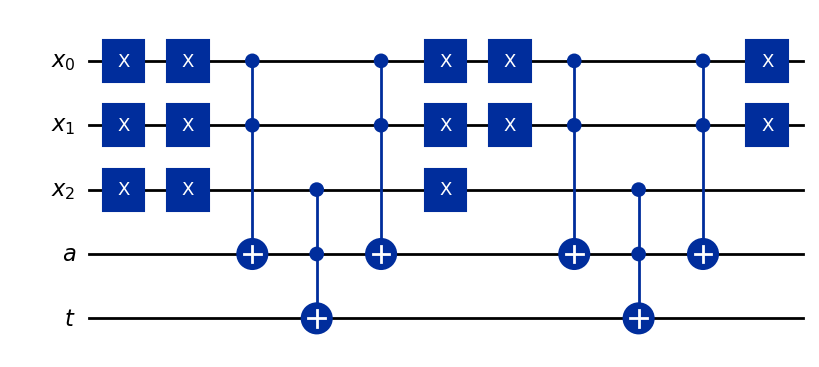

In [10]:
def is_equal(circuit,a,b,target,ancilla = [], decompose = True):

  """
  Check if a collection of qubits 'a' encoding the binary representation of an unknown entry
  is equal to an integer an element from a list of integers 'b', and records the output to 
  'target' as '0' if False and '1' if True.

  circuit: quantum circuit on which the gates are implemented
  a: (list of) qubit(s) that are being compared to 'b'
  b: a list of integers being compared to 'a'
  ancilla: stores ancilla qubits used in my MCX implementation. Not needed if decompose == False.
          If 'a' is an n-bit qubit, requires n-2 ancillas.
          
  target: a single qubit storing 1 if 'a' and 'b' encode the same value and '0' if not.
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.
  """

  # Create a list to store the binary representation of all integers in 'b'
  binary = []
  # For each integer in 'b', obtain its binary representation and add to our list
  for value in b:
      binary.append(f'{value:0{len(a)}b}')

  # For each value in 'b', implement the comparison to 'a' as described above,
  # and record the result in our target qubit, then uncompute.
  for value in binary:

      for j in [i for i in range(len(a)) if value[i] == '0']:
          circuit.x(a[j])

      MCX(circuit,a,target,ancilla,decompose = decompose)

      for j in [i for i in range(len(a)) if value[i] == '0']:
          circuit.x(a[j])


## Test Case

n = 3

list_of_integers = [0,1]

qubit = QuantumRegister(size = n,name = 'x')

if n - 2 > 0:
    ancilla = AncillaRegister(size = n-2,name = 'a')
else:
    ancilla = []
    
target = QuantumRegister(size = 1,name = 't')

qc = QuantumCircuit(qubit,ancilla,target)

qc.x(qubit)

is_equal(qc,qubit,list_of_integers,target,ancilla,decompose = True)

qc.draw(output='mpl')

# Statevector(qc).draw('Latex')

Finally, we introduce our generalized marker oracle, which now verifies that each unknown entry is in its list of allowed values and implements comparisons between the qubits encoding two unknown entries as before. It flips the sign of states for which the unknown entries encode a valid solution, and preserves the other states.

In [11]:
def marker_oracleNxN(puzzle,decompose = True):
  """ 
  Implement the marker oracle on our NxN puzzle, flipping the sign of states representing valid solutions
  and preserving states orthogonal to this.
  
  puzzle: NxN array or list of lists containing the values '0',...,'N-1', and 'None' encoding the positions of unknown entries
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.

  Return a quantum circuit implementing the marker oracle
  """

    # Ensure 'puzzle' is an array
  puzzle = np.array(puzzle)
    # Determine positions of unknown entries in puzzle
  unknown = unknown_entries(puzzle)

    # Compute the number of bits required to store unknown values, determined by the grid size
  bit_length = int(np.ceil(np.log(np.shape(puzzle)[0])/np.log(2)))

    # Create a dictionary mapping the (row,column) encoding of an unknown value to
  # the indices of the quantum registers encoding that qubit
  dictionary = {}

  for i in range(len(unknown)):
      dictionary[unknown[i]] = list(range(bit_length*i,bit_length*(i+1)))

    # Generate a list of entries to which the unknown entries must be compared. Either
  # to a fixed entry (fixed_comparisons) or to one another (unknown_comparisons).
  allowed_values, unknown_comparisons = generate_comparisons(puzzle,unknown)
    
    # Create quantum registers necessary for the computation:

    # Create a number of quantum registers = bit length * # of unknown entries to store the values
    # of the unknown entries
  quantum_register = QuantumRegister(size = bit_length*len(unknown),name = 'x')
    # Check target qubits equal to the number of checks we must perform to store the output of verifying
    # all unknown entries have appropriate values, and that any two unknown entries that are compared are distinct
  check_qubits = QuantumRegister(size = len(unknown)+len(unknown_comparisons), name = 'c')
    # Create a target qubit that registers '1' if all the checks are passed, and '0' if not
  target = QuantumRegister(size = 1, name = 't')

    
    # Introduce the necessary number of ancillas for our calculation, determined by whether or not MCX is decomposed
  if decompose == True and len(unknown)+len(unknown_comparisons)-2>0:
      ancilla_register = AncillaRegister(size = len(unknown)+len(unknown_comparisons)-2,name = 'a')
  else:
      ancilla_register = []

    # Create the quantum circuit 'check' with the above registers that does the necessary computation
    # to set the target to '1' if all checks are passed, and '0' if not
  checks = QuantumCircuit(quantum_register,check_qubits,target,ancilla_register, name = 'check')

    # For each unknown entry, check if it is among the list of allowed values for that entry with our is_equal function
  for i in range(len(unknown)):
      is_equal(checks,quantum_register[dictionary[unknown[i]]],allowed_values[i],check_qubits[i],decompose = False)

    # For any two unknown entries that must be distinct, check they are distinct with our XOR function
  for i in range(len(unknown_comparisons)):
      first,second = unknown_comparisons[i]
      XOR(checks,quantum_register[dictionary[first]],quantum_register[dictionary[second]],check_qubits[len(unknown)+i],both_qubits = True)

    
    # Evaluate if all checks are passed on the target qubit
  MCX(checks,check_qubits,target,ancilla_register,decompose=decompose)

    # Create a quantum circuit with the same registers to act as our marker circuit
  qc = QuantumCircuit(quantum_register,check_qubits,target,ancilla_register,name = 'marker')

    # Implement our 'check' circuit above
  qc.compose(checks,inplace=True)

    # Flip the sign of the state if the target qubit is '1', or don't if it is '0'
  qc.z(target)
    
    # Uncompute the 'check' circuit
  qc.compose(checks.inverse(),inplace=True)

    # Return the marker circuit
  return qc

# Test Case: Provide a puzzle and verify that the state has a sign flip iff the unknown entries
# are intialized to the correct value

puzzle =  [[0,1,2,3], [2,3,None,1], [1,2,3,0], [3,0,1,2]]
marker_oracleNxN(puzzle,decompose = True).draw(output='mpl')

Statevector(marker_oracleNxN(puzzle)).draw('Latex')

<IPython.core.display.Latex object>

We implement grover's algorithm as before by combining these ingredients:

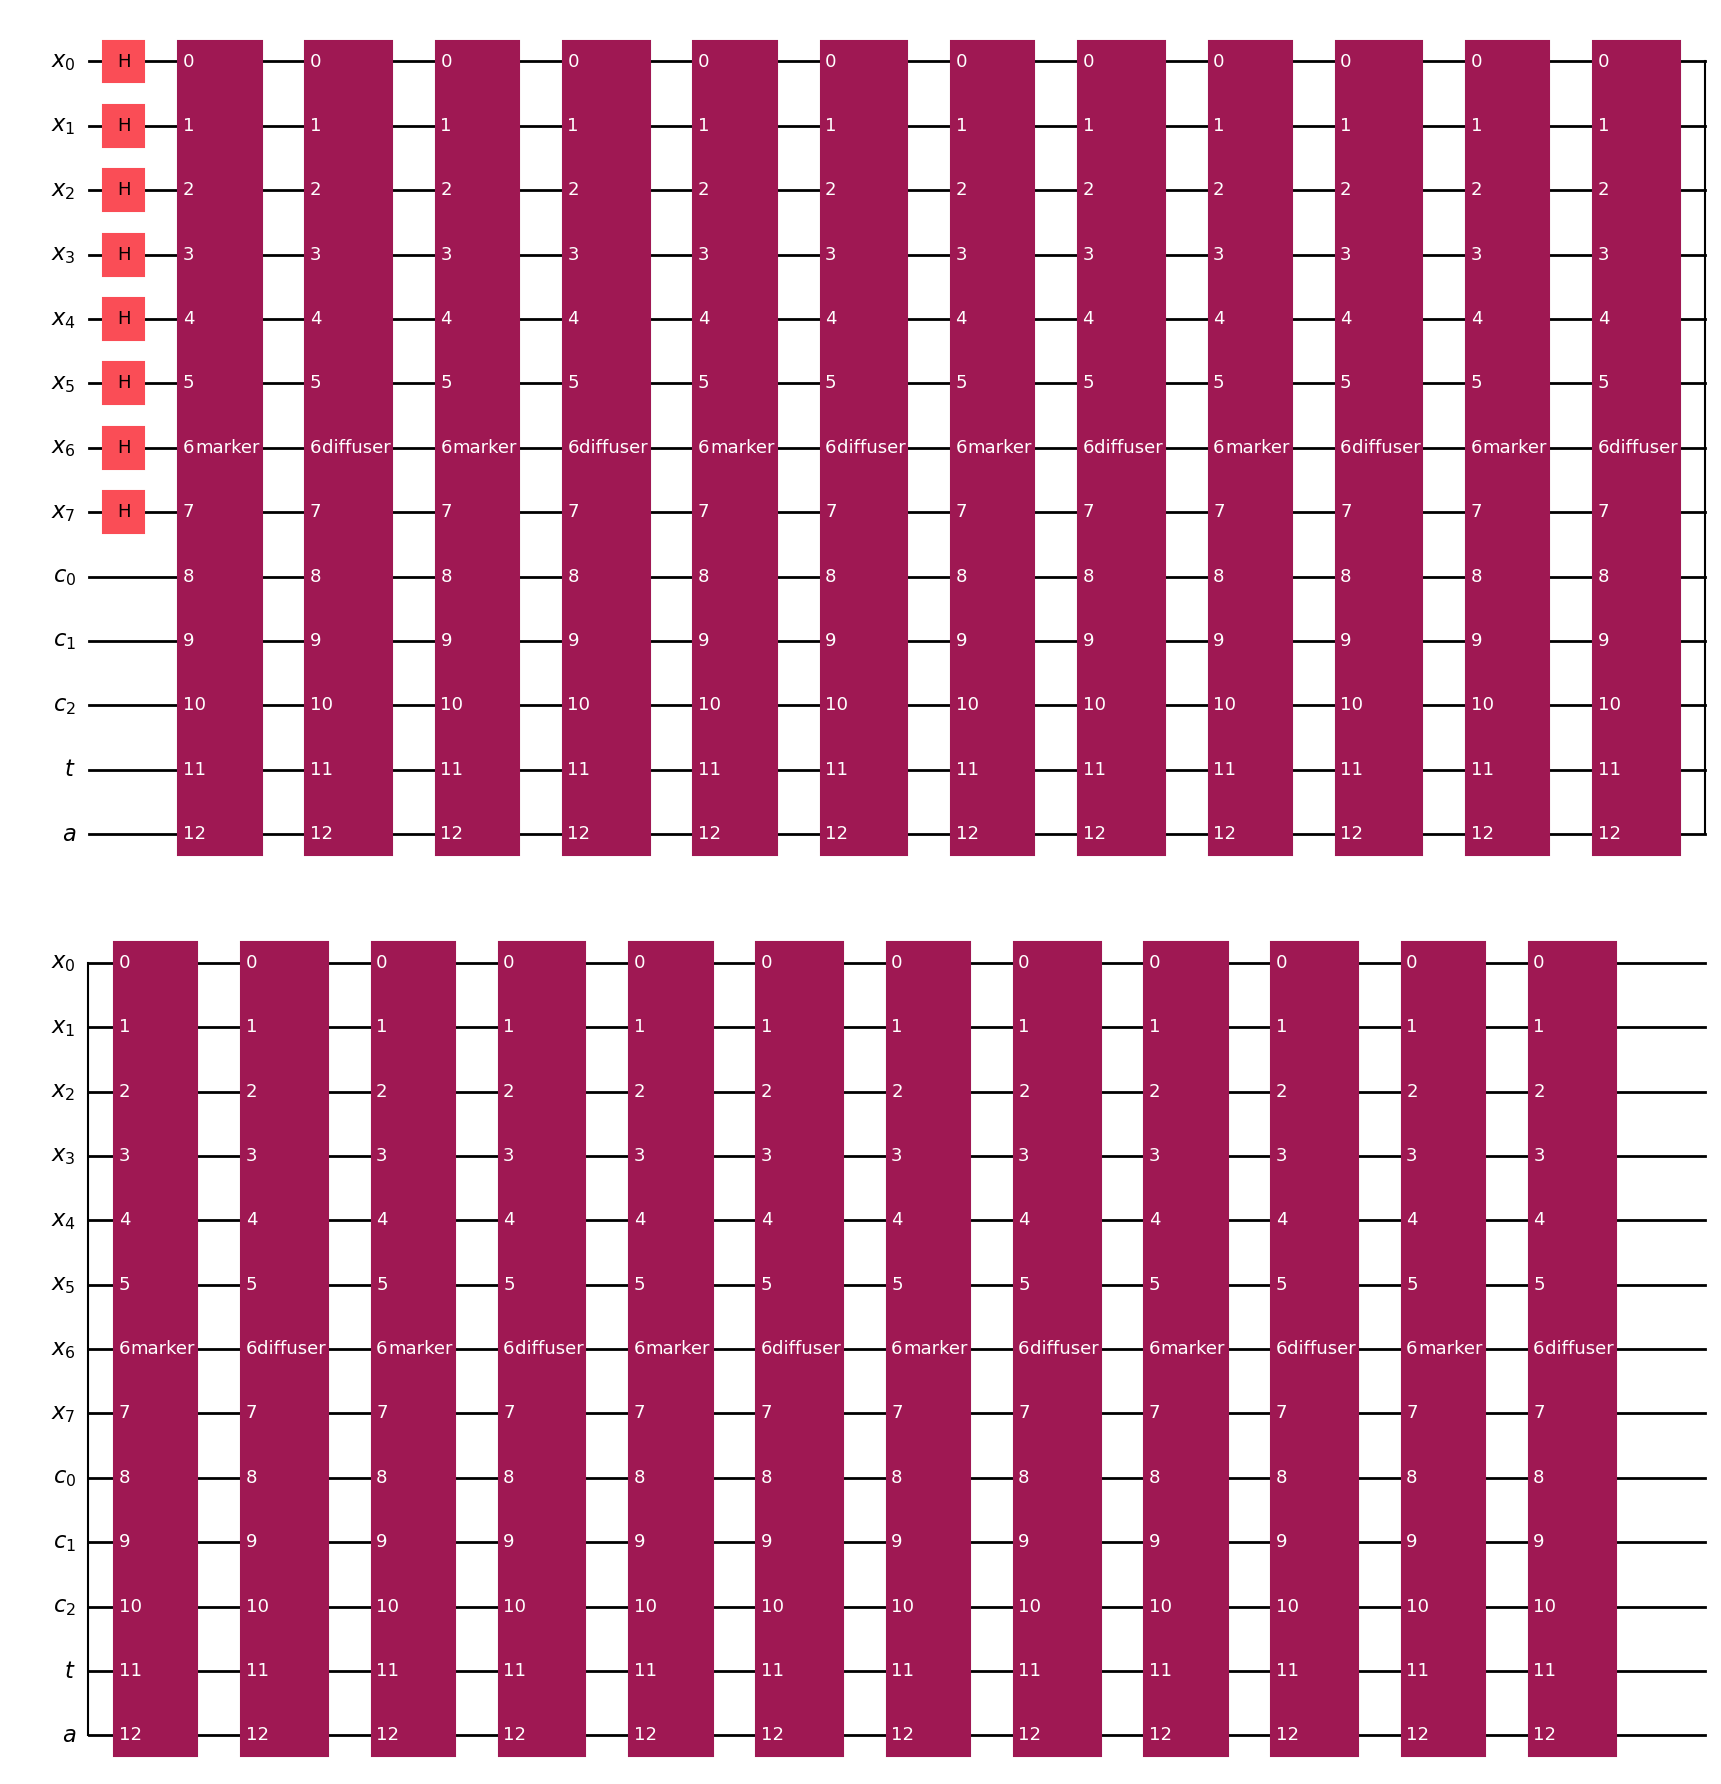

In [12]:
def GroverNxN(puzzle, decompose = True):
    """
  Implements Grover's alogirthm on a NxN sudoku or latin square.

  puzzle: NxN array or list of lists containing the values '0',...,'N-1', and 'None' encoding the positions of unknown entries
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.

  returns a circuit implementing Grover's algorithm to solve the puzzle!
    """
    # Determine locations unknown entries in the puzzle
    unknown = unknown_entries(puzzle)
    
    # Compute the number of bits required to store unknown values, determined by the grid size
    bit_length = int(np.ceil(np.log(np.shape(puzzle)[0])/np.log(2)))

    # Create a dictionary mapping the (row,column) encoding of an unknown value to
    # the indices of the quantum registers encoding that qubit
    dictionary = {}

    for i in range(len(unknown)):
        dictionary[unknown[i]] = list(range(bit_length*i,bit_length*(i+1)))

    # Generate a list of entries to which the unknown entries must be compared. Either
    # to a fixed entry (fixed_comparisons) or to one another (unknown_comparisons).
    allowed_values, unknown_comparisons = generate_comparisons(puzzle,unknown)

     # Create a number of quantum registers = bit length * # of unknown entries to store the values
     # of the unknown entries
    quantum_register = QuantumRegister(size = bit_length*len(unknown),name = 'x')
     # Check target qubits equal to the number of checks we must perform to store the output of verifying
     # all unknown entries have appropriate values, and that any two unknown entries that are compared are distinct
    check_qubits = QuantumRegister(size = len(unknown)+len(unknown_comparisons), name = 'c')
    # Create a target qubit that registers '1' if all the checks are passed, and '0' if not
    target = QuantumRegister(size = 1, name = 't')

    # Introduce the necessary number of ancillas for our calculation, determined by whether or not MCX is decomposed
    if decompose == True and len(unknown)+len(unknown_comparisons)-2>0:
        ancilla_register = AncillaRegister(size = len(unknown)+len(unknown_comparisons)-2,name = 'a')
    else:
        ancilla_register = []

    # Create the quantum circuit on these qubits for Grover's alogrithmm
    grover_circuit = QuantumCircuit(quantum_register,check_qubits,target,ancilla_register, name = 'grover')

    # Compute the number of iterations requires to converge to correct answer with maximum probability.
    N = 2**(bit_length*len(unknown))
    K = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(N))) - 1/2))

    # Prepare the state into an equal superposition state
    grover_circuit.h(quantum_register)

    # Create gates implementing the appropriate marker and diffuser circuits
    marker_circuit = marker_oracleNxN(puzzle,decompose).to_gate()
    diffuser_circuit = diffuser(bit_length*len(unknown),decompose = decompose).to_gate()

    # Iteratively apply the marker and diffuser gates the appropraite number of times
    for i in range(K):
        grover_circuit.compose(marker_circuit, inplace=True)
        grover_circuit.compose(diffuser_circuit,inplace=True)

    # Return the circuit implementing Grover's alogrithm
    return grover_circuit

# Verify the circuit diagram seems correct:

puzzle = np.array([[None,1,2,3,4,5,6,7,8],
 [3,4,5,6,7,8,0,1,2],
 [6,7,None,0,1,2,3,4,5],
 [1,2,3,4,5,6,7,8,0],
 [4,5,6,7,8,0,1,2,3],
 [7,8,0,1,2,3,4,5,6],
 [2,3,4,5,6,7,8,0,1],
 [5,6,7,8,0,1,2,3,4],
 [8,0,1,2,3,4,5,6,7]])

GroverNxN(puzzle, decompose = True).draw(output='mpl')

# Final "solve_puzzle" Function

And finally, we can package the whole thing into a user-friendly function:

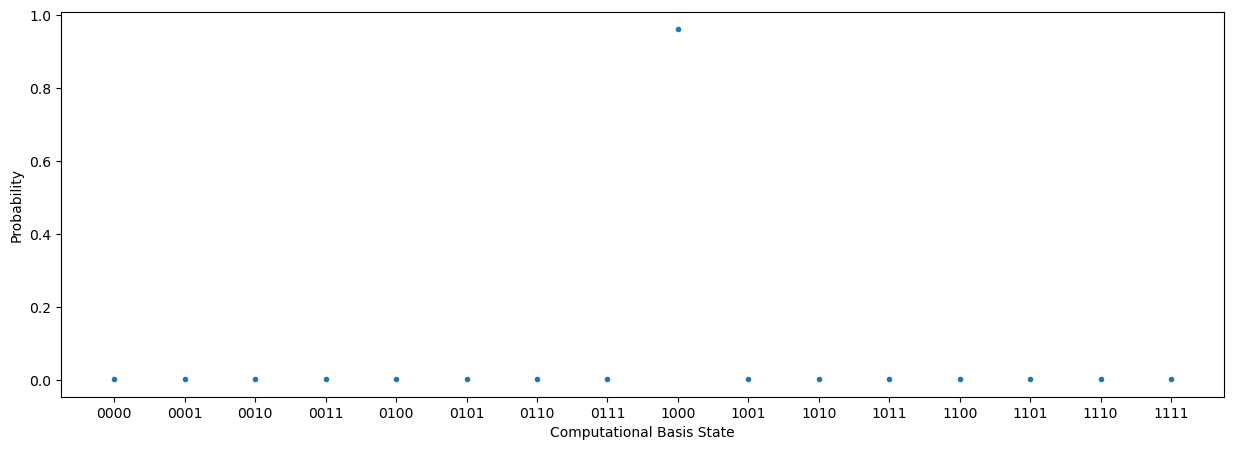

[0, 1]


In [15]:
def solve_puzzle(puzzle,decompose = True,showPlot = False):
    """
  User-friendly function packaging the implementation of Grover's algorithm to solve an NxN sudoku or Latin square.

  puzzle: NxN array or list of lists containing the values '0',...,'N-1', and 'None' encoding the positions of unknown entries.
  decompose: Boolean that reads 'True' when we want to use my MCX implementation, or 'False' to use the
            built in qiskit implementation.
  showPlot: Boolean that reads 'True' if user wishes to see a plot of the probability of all possible measurements
            of the qubits storing the unknown value state.

  Return a list of decimal numbers (integers) that correspond to the values of the unknown entries in the puzzle.
  These fill in the missing spaces in the puzzle in order, reading the puzzle from left-to-right and top-to-bottom.
    """
    # Make sure the puzzle is an array
    puzzle = np.array(puzzle)

    # If the puzzle is 2x2, we use the function we wrote for the 2x2 case
    if np.shape(puzzle)[0] == 2:
        return solve_puzzle2x2(puzzle, decompose = decompose, showPlot=showPlot)

    else:
        # Records the number of unknown entries
        unknown = unknown_entries(puzzle)
        # Records the number of bits required to store each entry, determined by the puzzle size
        bit_length = int(np.ceil(np.log(np.shape(puzzle)[0])/np.log(2)))

        # Implements Grover's algorithm and records the output state
        psi = Statevector(GroverNxN(puzzle,decompose=decompose))

        # Create a list to store the binary representation of all possible outputs
        binary = []
        for i in range(2**(bit_length*len(unknown))):
            binary.append(f"{i:0{len(unknown)*bit_length}b}")

        # Create a list of the probabilities of each output from the state
        probability = list(psi.probabilities()[:2**(bit_length*len(unknown))])

        # Find the computational basis state with the largest probability
        max_index = probability.index(max(probability))
        backward_solution = binary[max_index]

        # Flip the bit order around to be in the more natural ordering
        solution = ''.join(reversed(backward_solution))

        # Plot the probabilities if showPlot == True
        if showPlot == True:
            plt.figure(figsize = (15,5))
            plt.plot(binary,probability,'.')
            plt.xlabel('Computational Basis State')
            plt.ylabel('Probability')
            plt.show()

        # Create an array to store the decimal values of each unknown entry in the determined solution
        decimal_solution = []

        # Convert the binary representation of each entry into decimal
        for i in range(int(len(solution)/bit_length)):
            decimal_solution.append(int(solution[bit_length*i:bit_length*i+bit_length],2))

        # Return the list of decimal values
        return decimal_solution

## Testing: Enter your favorite N x N puzzle with 'None' for the correct entries. Commented below are examples of fully solved
## puzzles for 2x2, 3x3, 4x4, and 9x9. You can replace any of the entries with 'None' and verify that the alogrithm 
## correctly recovers valid entries.
puzzle =  [[0,1,2,3],
            [2,3,0,1],
            [1,2,3,0],
            [3,None,None,2]]

print(solve_puzzle(puzzle,False,True))


# [[1,0],
# [0,1]]

# [[0,1,2],
#  [1,2,0],
#  [2,0,1]]

# [[0,1,2,3]
# [2,3,0,1]
# [1,2,3,0]
# [3,0,1,2]]


# [[0,1,2,3,4,5,6,7,8],
#  [3,4,5,6,7,8,0,1,2],
#  [6,7,8,0,1,2,3,4,5],
#  [1,2,3,4,5,6,7,8,0],
#  [4,5,6,7,8,0,1,2,3],
#  [7,8,0,1,2,3,4,5,6],
#  [2,3,4,5,6,7,8,0,1],
#  [5,6,7,8,0,1,2,3,4],
#  [8,0,1,2,3,4,5,6,7]]